In [1]:
import autograd.numpy as np
from scipy.integrate import solve_bvp, odeint
from matplotlib import pyplot as plt
from autograd import grad, elementwise_grad

In [11]:
class HodgkinHuxley():
    """Full Modified Hodgkin-Huxley Model implemented in Python"""

    C_m  =   1.0
    """membrane capacitance, in uF/cm^2"""

    g_Na = 120.0
    """Sodium (Na) maximum conductances, in mS/cm^2"""

    g_K  =  36.0
    """Postassium (K) maximum conductances, in mS/cm^2"""

    g_L  =   0.3
    """Leak maximum conductances, in mS/cm^2"""

    E_Na =  50.0
    """Sodium (Na) Nernst reversal potentials, in mV"""

    E_K  = -77.0
    """Postassium (K) Nernst reversal potentials, in mV"""

    E_L  = -54.387
    """Leak Nernst reversal potentials, in mV"""

    t = np.arange(0.0, 50.0, 0.01)
    """ The time to integrate over """

    def o(self, V, scalar=0.75):
        return (np.tanh((V + 55) * scalar) / 2) + 0.5
    
    def d(self, V, scalar=0.75):
        return 1

    def r(self, V):
        return int(V < -65)

    def alpha_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.01*(V+55.0)/(1.0 - np.exp(-(V+55.0) / 10.0))

    def beta_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.125*np.exp(-(V+65) / 80.0)

    def I_Na(self, V, c, h):
        """
        Membrane current (in uA/cm^2)
        Sodium (Na = element name)
        """
        return self.g_Na * (1 - c - h) * (V - self.E_Na)

    def I_K(self, V, n):
        """
        Membrane current (in uA/cm^2)
        Potassium (K = element name)

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_K  * n**4 * (V - self.E_K)
    
    #  Leak
    def I_L(self, V):
        """
        Membrane current (in uA/cm^2)
        Leak

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_L * (V - self.E_L)

    def I_inj(self, t):
        """
        External Current

        |  :param t: time
        |  :return: step up to 10 uA/cm^2 at t>100
        |           step down to 0 uA/cm^2 at t>200
        |           step up to 35 uA/cm^2 at t>300
        |           step down to 0 uA/cm^2 at t>400
        """
        ## NOTE: the following line used to read # + 35*(t>300) - 35*(t>400)
        return 10*(t>100) - 10*(t>200) + 25*(t>300) - 25*(t>400)

    @staticmethod
    def dALLdt(X, t, self):
        """
        Integrate

        |  :param X:
        |  :param t:
        |  :return: calculate membrane potential & activation variables
        """
        V, c, h, n = X

        dVdt = (self.I_inj(t) - self.I_Na(V, c, h) - self.I_K(V, n) - self.I_L(V)) / self.C_m
        
        # our new SIR model
        dcdt = self.r(V)*h - self.o(V)*c
        dhdt = self.d(V)*(1 - c - h) - self.r(V)*h
        
        dndt = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
        return dVdt, dcdt, dhdt, dndt

    def get_initial_conditions(self, plot=False):
        """
        Main demo for our altered Hodgkin Huxley neuron model
        """
        # TODO: new initial conditions
        X = odeint(self.dALLdt, [-65, 1, 0, 0.32], self.t, args=(self,))
        
        V = X[:,0]
        c = X[:,1]
        h = X[:,2]
        n = X[:,3]
        
        ina = self.I_Na(V, c, h)
        ik = self.I_K(V, n)
        il = self.I_L(V)
        
        y = [
            V[-1],
            n[-1],
            (1 - c - h)[-1],
            h[-1],
            c[-1],
        ]

        if plot:
            plt.figure(figsize=(15,10))

            plt.subplot(4,1,1)
            plt.title('Getting Steady State Initial Conditions for Neuron Model')
            plt.plot(self.t, V, 'k')
            plt.ylabel('V (mV)')

            plt.subplot(4,1,2)
            plt.plot(self.t, ina, 'c', label='$I_{Na}$')
            plt.plot(self.t, ik, 'y', label='$I_{K}$')
            plt.plot(self.t, il, 'm', label='$I_{L}$')
            plt.ylabel('Current')
            plt.legend()

            plt.subplot(4,1,3)
            plt.plot(self.t, c, 'r', label='c')
            plt.plot(self.t, h, 'g', label='h')
            plt.plot(self.t, 1 - c - h, 'y', label='m')
            plt.plot(self.t, n, 'b', label='n')
            plt.ylabel('Gating Value')
            plt.legend()

            plt.subplot(4,1,4)
            i_inj_values = [self.I_inj(t) for t in self.t]
            plt.plot(self.t, i_inj_values, 'k')
            plt.xlabel('t (ms)')
            plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
            plt.ylim(-1, 40)

            plt.show()
        
        return y

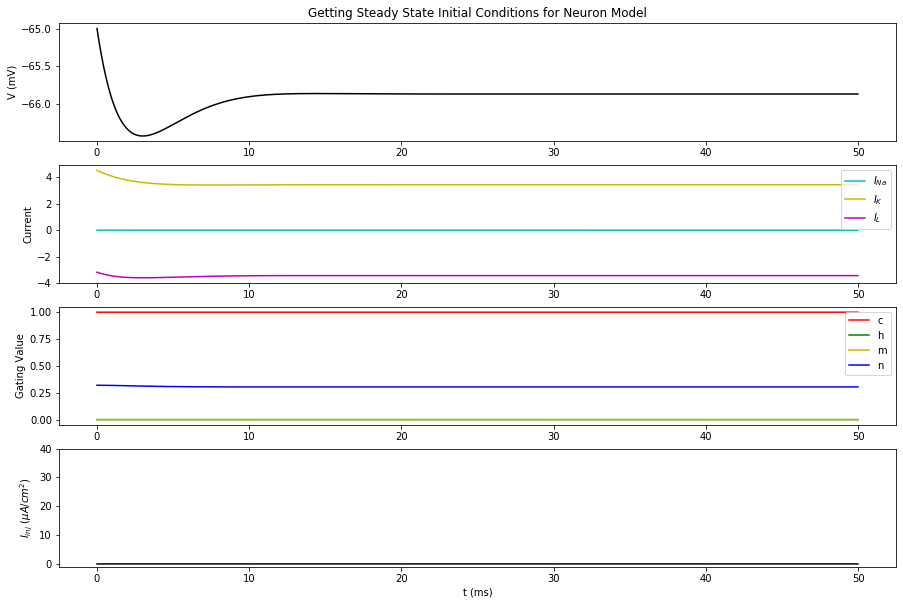

[-65.86658911024426,
 0.3044848969890941,
 8.337776667981155e-08,
 8.337820757149762e-08,
 0.9999998332440257]

In [12]:
runner = HodgkinHuxley()
runner.get_initial_conditions(plot=True)

In [17]:
C_m  =   1.0
# membrane capacitance, in uF/cm^2

g_Na = 120.0
# Sodium (Na) maximum conductances, in mS/cm^2

g_K  =  36.0
# Postassium (K) maximum conductances, in mS/cm^2

g_L  =   0.3
# Leak maximum conductances, in mS/cm^2

V_Na =  50.0
# Sodium (Na) Nernst reversal potentials, in mV

V_K  = -77.0
# Postassium (K) Nernst reversal potentials, in mV

V_L  = -54.387
# Leak Nernst reversal potentials, in mV

I = 30
# injected current

def alpha_n(V):
    """Channel gating kinetics. Functions of membrane voltage"""
    return 0.01*(V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

dalpha_n = elementwise_grad(alpha_n)

def beta_n(V):
    """Channel gating kinetics. Functions of membrane voltage"""
    return 0.125*np.exp(-(V+65) / 80.0)

dbeta_n = elementwise_grad(beta_n)

def o(V, scalar=0.75):
    return (np.tanh((V + 55) * scalar) / 2) + 0.5

do = elementwise_grad(o)

def d(V, scalar=0.75):
    return np.ones_like(V)

dd = lambda x: 0

def r(V):
    return V < -65

dr = elementwise_grad(r)

/Users/rexboyce/opt/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")
/Users/rexboyce/opt/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
/Users/rexboyce/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less
/Users/rexboyce/opt/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in less
  return f_raw(*args, **kwargs)


[-0.75468044]


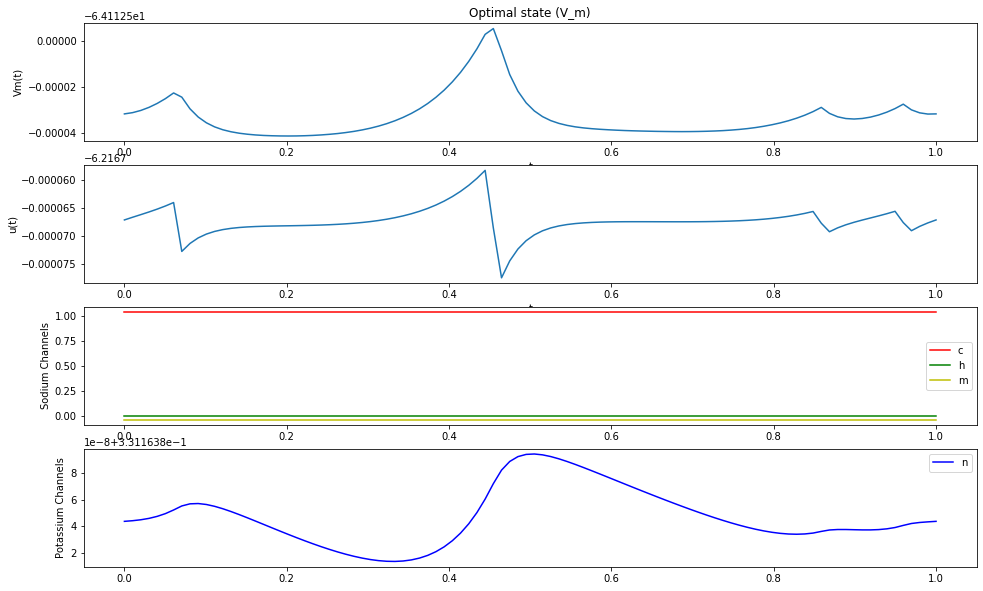

In [23]:
def f(t, y, tf):
    # unpack values from state, costate
    Vm, n, m, h, c, p1, p2, p3, p4, p5 = y
    
    # state evolution eqs
    u = np.log(p1 * g_Na * m * (Vm - V_Na)) - np.log(2 * C_m)
    au = (u + 1) * (2 * C_m) / (p1 * g_Na * m * (Vm - V_Na))
    dVm = I - g_K * n**4 * (Vm - V_K) - g_L * (Vm - V_L) - g_Na * m * au * (Vm - V_Na)
    dn = alpha_n(Vm) * (1 - n) - beta_n(Vm) * n
    dm = o(Vm) * c - d(Vm) * m
    dh = d(Vm) * m - r(Vm) * h
    dc = r(Vm) * h - o(Vm) * c
    
    # costate evolution eqs
    pVm = p1 * (-g_K * n**4 - g_L - g_Na * m * au)/C_m \
        + p2 * (dalpha_n(Vm) * (1 - n)- dbeta_n(Vm) * n)\
        + p3 * (do(Vm) * c - dd(Vm) * m) \
        + p4 * (dd(Vm) * m - dr(Vm) * h) \
        + p5 * (dr(Vm) * h - do(Vm) * c)
    pn = p1 * (-4 * g_K * (n**3) * (Vm - V_K)) / C_m - p2 * (alpha_n(Vm) + beta_n(Vm))
    pm = p1 * (-g_Na * au * (Vm-V_Na)) / C_m - p3 * d(Vm) + p4 * d(Vm)
    ph = -p4 * r(Vm) + p5 * d(Vm)
    pc = p3 * o(Vm) - p5 * o(Vm)
     
    return tf[0]*np.array([dVm, dn, dm, dh, dc, pVm, pn, dm, ph, pc])

def bc(ya, yb, tf):
    Vm, n, m, h, c, p1, p2, p3, p4, p5 = yb
    u = np.log(p1 * g_Na * m * (Vm - V_Na)) - np.log(2 * C_m)
    au = (u + 1) * (2 * C_m) / (p1 * g_Na * m * (Vm - V_Na))
    dVm = I - g_K * n**4 * (Vm - V_K) - g_L * (Vm - V_L) - g_Na * m * au * (Vm - V_Na)
    dn = alpha_n(Vm) * (1 - n) - beta_n(Vm) * n
    dm = o(Vm) * c - d(Vm) * m
    dh = d(Vm) * m - r(Vm) * h
    dc = r(Vm) * h - o(Vm) * c
    
    return np.array([
        ya[0] - yb[0],
        ya[1] - yb[1],
        ya[2] - yb[2],
        ya[3] - yb[3],
        ya[4] - yb[4],
        ya[5] - yb[5],
        ya[6] - yb[6],
        ya[7] - yb[7],
        ya[8] - yb[8],
        ya[9] - yb[9],
        p1 * dVm + p2 * dn + p3 * dm + p4 * dh + p5 * dc - u**2 - 2*(tf[0] - T)
    ])

n_dims, n_points = 10, 100
t = np.linspace(0, 1, n_points)

runner = HodgkinHuxley()
y = runner.get_initial_conditions()
y_guess = np.hstack((
    y,
    -1*np.ones(5)
))
y_guess = np.vstack(
    [y_guess] * n_points
).T

tf_guess = [12.5]
T = 15

sol = solve_bvp(f, bc, t, y_guess, tf_guess)
print(sol.p)

# unpack values from state, costate
Vm, n, m, h, c, p1, p2, p3, p4, p5 = sol.y

# state evolution eqs
u = np.log(p1 * g_Na * m * (Vm - V_Na)) - np.log(2 * C_m)

# plot results
plt.figure(figsize=(16,10))
plt.subplot(411)
plt.plot(sol.x, Vm)
plt.xlabel("t")
plt.ylabel("Vm(t)")
plt.title("Optimal state (V_m)")

plt.subplot(412)
plt.plot(sol.x, u)
plt.xlabel("t")
plt.ylabel("u(t)")

plt.subplot(413)
plt.plot(sol.x, c, 'r', label='c')
plt.plot(sol.x, h, 'g', label='h')
plt.plot(sol.x, 1 - c - h, 'y', label='m')
plt.ylabel('Sodium Channels')
plt.legend()

plt.subplot(414)
plt.plot(sol.x, n, 'b', label='n')
plt.ylabel('Potassium Channels')
plt.legend()

plt.show()